# Accent Classification on TTBacc

This notebook is a sample of classification between two accents: *Paulistano* (PLST) and *Nordestino* (NRD). The code that follows
uses the TTBAcc dataset, collected from TED Talks in Portuguese and further curated.

In [21]:
import pandas as pd
import pathlib
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

DATAPATH = pathlib.PosixPath("~/Dev/datasets/ttbacc/ttbacc-feats.csv").expanduser()

In [22]:
ttbacc = pd.read_csv(DATAPATH)

In [23]:
len(ttbacc.index)

73425

Filter the states that represent the accents, rename the *Nordestino* states to NRD, and rename the *Paulistano* to PLST

In [24]:
valid_states = ["AL", "PE", "PB", "RN", "CE", "SP"]
ttbacc_dual = ttbacc[ttbacc["state"].isin(valid_states)]
nrd_states = valid_states[:-1]
ttbacc_nrd_plst = ttbacc_dual.replace(nrd_states, "NRD")
ttbacc_nrd_plst = ttbacc_nrd_plst.replace("SP", "PLST")

In [25]:
ttbacc_nrd_plst

mfcc1     mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  \
802    -9.337446  4.580215  10.015017 -22.148359 -19.074935 -25.727883   
806    -9.525597 -2.411771  -2.280417 -16.610845 -15.567915 -21.938533   
811   -11.062094 -2.793278  -0.774705 -15.762328 -16.836987 -19.530863   
817   -12.305371  3.029171  -0.134277 -17.811747 -18.708913 -19.219496   
826   -15.939765  0.126131  -0.307999 -11.677003 -15.726257 -20.614417   
...          ...       ...        ...        ...        ...        ...   
73223 -11.377018 -0.229847   6.404932 -15.603588 -11.270944 -17.827044   
73224 -15.811949  4.375625   1.599705  -4.535742 -18.389920 -14.184399   
73225 -11.384714  2.917409   7.494513 -20.976519  -9.621344 -12.591542   
73226  -8.149513 -3.320875   2.726281 -18.108985  -8.872262  -9.517556   
73227 -12.349031  8.685121  -5.775504  -3.255217 -15.488943 -21.347473   

           mfcc7      mfcc8      mfcc9    mfcc10  ...    delta5    delta6  \
802    -4.885701  -4.255625  -3.489977 -0.694959  ...  0.056740 -0.093647   
806    -5.387356  -3.163532  -1.807162  0.094535  ...  0.071489 -0.033987   
811    -1.626003   0.257247  -2.295600 -3.563486  ... -0.019890 -0.032311   
817    -4.926544  -4.454221  -4.920454  2.724337  ... -0.093826  0.042975   
826    -5.871992  -0.128986  -6.898337 -2.761597  ...  0.043122 -0.019044   
...          ...        ...        ...       ...  ...       ...       ...   
73223 -15.156779  -1.070279 -11.648948 -2.379622  ... -0.007892 -0.046576   
73224  -6.528083  -4.994925  -5.241554 -4.184387  ...  0.092605  0.052084   
73225 -12.909317  -7.299075  -9.167448 -8.715821  ... -0.005943  0.015128   
73226 -14.644305  -6.789744 -14.401577 -7.989024  ...  0.051134  0.030200   
73227 -12.967329 -10.435369  -1.221921 -7.126131  ...  0.213020  0.340728   

         delta7    delta8    delta9   delta10   delta11   delta12  \
802   -0.009014 -0.035593 -0.083217  0.037068 -0.021209  0.073755   
806    0.029767  0.071917 -0.024157  0.040457  0.036941 -0.008153   
811   -0.048265  0.036565  0.090687 -0.049308  0.019536 -0.015181   
817    0.022809 -0.070964 -0.001145  0.007463  0.062893  0.040363   
826    0.032335  0.003248  0.006135  0.015996  0.041590  0.033047   
...         ...       ...       ...       ...       ...       ...   
73223 -0.002637  0.022978 -0.008628  0.055222  0.006132  0.039451   
73224  0.025615  0.066230 -0.019236  0.049827 -0.001315 -0.012830   
73225 -0.008793  0.031478  0.040656  0.033940 -0.080111 -0.005182   
73226  0.101043  0.027909 -0.034161 -0.093703 -0.029168  0.081621   
73227 -0.118584 -0.218407 -0.009996  0.371885 -0.239889 -0.174159   

                   fname  state  
802      ted-talk-0123-0   PLST  
806      ted-talk-0123-1   PLST  
811      ted-talk-0123-2   PLST  
817      ted-talk-0123-3   PLST  
826      ted-talk-0123-4   PLST  
...                  ...    ...  
73223  ted-talk-0793-108   PLST  
73224  ted-talk-0793-109   PLST  
73225  ted-talk-0793-110   PLST  
73226  ted-talk-0793-111   PLST  
73227  ted-talk-0793-112   PLST  

[27766 rows x 26 columns]

Look for empty, invalid, or null values in the dataset.

In [26]:
ttbacc_nrd_plst.isna().sum()

mfcc1      0
mfcc2      0
mfcc3      0
mfcc4      0
mfcc5      0
mfcc6      0
mfcc7      0
mfcc8      0
mfcc9      0
mfcc10     0
mfcc11     0
mfcc12     0
delta1     0
delta2     0
delta3     0
delta4     0
delta5     0
delta6     0
delta7     0
delta8     0
delta9     0
delta10    0
delta11    0
delta12    0
fname      0
state      0
dtype: int64

Split data into training and test, while preserving accents ratio

In [27]:
ttbacc_X = ttbacc_nrd_plst.drop(["fname", "state"], axis=1)
ttbacc_Y = ttbacc_nrd_plst["state"]

In [28]:
ttbacc_splits = train_test_split(
    ttbacc_X, ttbacc_Y, test_size=0.3, random_state=42, shuffle=True, stratify=ttbacc_Y
)
ttbacc_xtrain, ttbacc_xtest, ttbacc_ytrain, ttbacc_ytest = ttbacc_splits 

In [29]:
len(ttbacc_xtrain.index), len(ttbacc_xtest.index)

(19436, 8330)

Create a baseline predictor, which is a simple classifier that predicts everything as PLST. Given the ratio of this class 
in the dataset, the dummy classifier has an accuracy of 90.2%.

In [30]:
def dummy_predict(X):
    return ["PLST"] * len(X.index)

In [31]:
acc = accuracy_score(ttbacc_ytest, dummy_predict(ttbacc_xtest))
print("DUMMY")
print(classification_report(ttbacc_ytest, dummy_predict(ttbacc_xtest), zero_division=0, digits=3))

DUMMY
              precision    recall  f1-score   support

         NRD      0.000     0.000     0.000       818
        PLST      0.902     1.000     0.948      7512

    accuracy                          0.902      8330
   macro avg      0.451     0.500     0.474      8330
weighted avg      0.813     0.902     0.855      8330



Now, use a Decision Tree, KNN, and SVM to accent classification in TTBAcc. The models are fine tuned in the training set with a grid-search over the `hyperparams`. After, there is a single run in the test set, evaluating the model's generalisation. Results are presented in terms of accuraccy, weighted precision and recall, and the confusion matrix for further metric computation.

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=42)
TRAIN ACC: 92.01
              precision    recall  f1-score   support

         NRD     0.6310    0.5978    0.6139       818
        PLST     0.9565    0.9619    0.9592      7512

    accuracy                         0.9262      8330
   macro avg     0.7937    0.7799    0.7866      8330
weighted avg     0.9245    0.9262    0.9253      8330



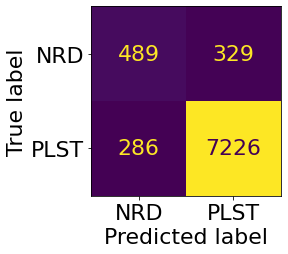

KNeighborsClassifier(metric='euclidean', n_neighbors=4, weights='distance')
TRAIN ACC: 97.59
              precision    recall  f1-score   support

         NRD     0.9086    0.8386    0.8722       818
        PLST     0.9826    0.9908    0.9867      7512

    accuracy                         0.9759      8330
   macro avg     0.9456    0.9147    0.9294      8330
weighted avg     0.9753    0.9759    0.9754      8330



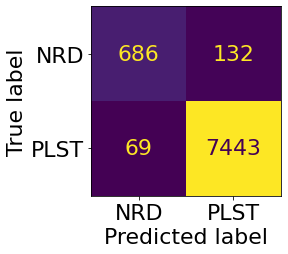

In [ ]:
# KNN, SVM, TREE
# Baseline is 90%
%matplotlib inline

hyperparams = [
    {"criterion": ["gini", "entropy", "log_loss"]}, # Decision
    {
        "n_neighbors": [4, 8, 16, 32],
        "metric": ["cityblock", "euclidean", "cosine"],
        "weights": ["uniform", "distance"],  # KNN
    },
    {"C": [0.1, 0.01, 1], "kernel": ["linear", "rbf", "sigmoid"]}, # SVC
]
clfs = {
    "dtree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "knn": KNeighborsClassifier(),
    "svm": SVC(random_state=42, class_weight="balanced"),
}

for clf, params in zip(clfs, hyperparams):
    gs = GridSearchCV(clfs[clf], params, cv=5)
    gs.fit(ttbacc_xtrain, ttbacc_ytrain)
    
    print(gs.best_estimator_)
    print(f"TRAIN ACC: {100*gs.best_score_:.2f}")
    results_cv = pd.DataFrame(gs.cv_results_)
    results_cv.to_csv(f"../results/{clf}.csv", index=False)
    
    test_preds = gs.best_estimator_.predict(ttbacc_xtest)
    acc = accuracy_score(ttbacc_ytest, test_preds)
    print(classification_report(ttbacc_ytest, test_preds, zero_division=0, digits=4))
    
    default_font_size = rcParams["font.size"]
    rcParams["font.size"] = 22
    cfm = confusion_matrix(ttbacc_ytest, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["NRD", "PLST"])
    disp.plot(cmap="viridis", colorbar=clf == "svm")
    plt.tight_layout()
    plt.savefig(f"../imgs/{clf}-cfm.pdf", dpi=300)
    plt.show()
    rcParams["font.size"] = default_font_size
    
    dump(gs.best_estimator_, f"../results/{clf}.joblib")